<a href="https://colab.research.google.com/github/mosrihari/FoundationalStudy/blob/main/GPT_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
GPT2_CFG = {
    "vocab_size"    : 50257,
    "emb_dim"       : 768,
    "n_heads"       : 12,
    "n_transformers": 12,
    "dropout"       : 0.1,
    "context_len"   : 1024,
    "qkv_bias"      : False
}

# Transformer Layer components

Transformer layer consists of


*   Layer Normalization
*   Feedforward neural network with GELU
*   Skip Connection
*   Masked Multi head attention

So we will implement each layers as a separate class which forms transformers





## Layer Normalization

### Scratchpad

In [3]:
input_layer = torch.randn((5,6))
print(input_layer)

torch.mean(input_layer,dim=-1)

tensor([[-1.6819, -0.7063, -0.7825, -0.0800,  1.7600,  0.3343],
        [ 0.3159, -0.4372, -0.0829, -0.3775,  0.5924,  0.4966],
        [ 2.5865,  1.3612, -0.4108, -0.4806, -0.5937,  1.0252],
        [-0.4306, -0.0760,  0.8329,  0.7969, -0.0902, -2.4184],
        [ 0.0868, -1.7293,  0.6421, -0.0703,  0.5666,  0.3972]])


tensor([-0.1927,  0.0845,  0.5813, -0.2309, -0.0178])

### Main class

In [4]:
class LayerNormalization(torch.nn.Module):

  def __init__(self, eps):
    super().__init__()

    self.eps = eps #to avoid divide by 0
    self.scale = torch.nn.Parameter(torch.ones((GPT2_CFG['context_len'], GPT2_CFG['emb_dim'])))
    self.shift = torch.nn.Parameter(torch.zeros((GPT2_CFG['context_len'], GPT2_CFG['emb_dim'])))

  def forward(self, x):
    # we take mean and variance from the output layer
    # The output layer will have embedding_dim as column matrix
    # Hence the mean and variance should be across columns
    mean = torch.mean(x, dim=-1, keepdim=True) #normalize across columns -1
    variance = torch.var(x, dim=-1, unbiased=True, keepdim=True) # unbiased True for bressels correction
    # keepdim is mandatory as it preserves the dimension. Else, the mean and variance will be flattened vectors
    x = (x - mean) / (torch.sqrt(variance) + self.eps) # normalize
    return self.scale * x + self.shift # trainable params included


In [5]:
#small testing
input_matrix = [[1,2,3,4,5],
                [3,4,5,21,32],
                [12,324,233,5456,32],
                [12,34,3,6,1],
                [78,43,23,12,65]]

#input_matrix 5 * 5
input_matrix = torch.tensor(input_matrix).float()
LM = LayerNormalization(eps = 1e-5)
LM.scale = torch.nn.Parameter(torch.ones((5,5)))
LM.shift = torch.nn.Parameter(torch.zeros((5,5)))
output_normalized = LM(input_matrix)

print(output_normalized, output_normalized.shape, torch.mean(output_normalized, dim=-1), torch.var(output_normalized, dim=-1))

tensor([[-1.2649, -0.6325,  0.0000,  0.6325,  1.2649],
        [-0.7727, -0.6954, -0.6181,  0.6181,  1.4681],
        [-0.5047, -0.3734, -0.4117,  1.7861, -0.4963],
        [ 0.0597,  1.7008, -0.6117, -0.3879, -0.7609],
        [ 1.2215, -0.0434, -0.7661, -1.1637,  0.7517]], grad_fn=<AddBackward0>) torch.Size([5, 5]) tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.1921e-08, -4.7684e-08],
       grad_fn=<MeanBackward1>) tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<VarBackward0>)


In [6]:
LM = LayerNormalization(eps = 1e-5)
input_x = torch.randn((GPT2_CFG['context_len'], GPT2_CFG['emb_dim']))
output_normalized = LM(input_x)
output_normalized.shape, torch.mean(output_normalized), torch.var(output_normalized)
# Mean 0 and Variance 1

(torch.Size([1024, 768]),
 tensor(1.5522e-10, grad_fn=<MeanBackward0>),
 tensor(0.9987, grad_fn=<VarBackward0>))

## Feedforward with GELU

### GELU



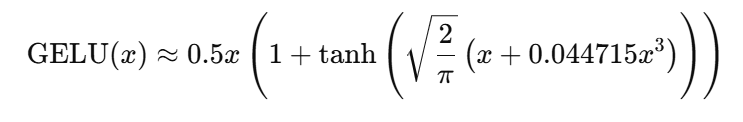

In [7]:
class GELU(torch.nn.Module):

  def __init__(self):
    super().__init__()

  def forward(self, x):
    # Inside GELU activation
    return 0.5 * x * (1 +
                      torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) *
                       (x + 0.044715 * torch.pow(x, 3))))

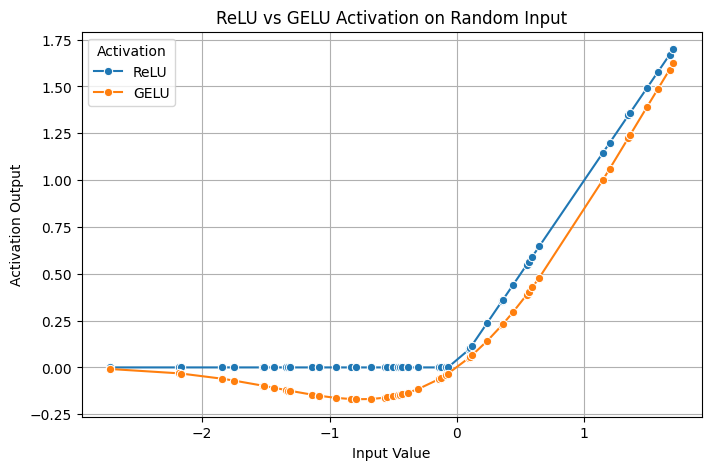

In [8]:
## We can do comparison between RELU and GELU as well
input_values = torch.randn(50)
relu_activation = torch.relu(input_values)
gelu = GELU()
gelu_activation = gelu(input_values)

df = pd.DataFrame({
    'Input': input_values.numpy(),
    'ReLU': relu_activation.numpy(),
    'GELU': gelu_activation.numpy()
})

df_melted = df.melt(id_vars='Input', var_name='Activation', value_name='Output')

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_melted, x='Input', y='Output', hue='Activation', marker='o')
plt.title('ReLU vs GELU Activation on Random Input')
plt.xlabel('Input Value')
plt.ylabel('Activation Output')
plt.grid(True)
plt.show()

### Feedforward network

In [9]:
class FeedforwardNetwork(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.layers = torch.nn.Sequential(
        torch.nn.Linear(GPT2_CFG['emb_dim'], GPT2_CFG['emb_dim']*4), #expansion
        GELU(), #activation defined by us
        torch.nn.Linear(GPT2_CFG['emb_dim'] * 4, GPT2_CFG['emb_dim']) #contraction
    )

  def forward(self, x):
    x = self.layers(x)
    return x

In [10]:
input_x = torch.randn((GPT2_CFG['emb_dim'], GPT2_CFG['emb_dim']))
FFN = FeedforwardNetwork()
final_output = FFN(input_x)

In [11]:
final_output.shape

torch.Size([768, 768])

In [12]:
for name, param in FFN.named_parameters():
    print(name, param.shape)

layers.0.weight torch.Size([3072, 768])
layers.0.bias torch.Size([3072])
layers.2.weight torch.Size([768, 3072])
layers.2.bias torch.Size([768])


## Shortcut Connection understanding

We are just going to check the Shortcut connection to understand how it works for multiple layers. This is not part of implementation class as it is passing previous input to further outputs only. Which we will do in main transformer class

In [13]:
class ShortCutConnection(torch.nn.Module):

  def __init__(self, shortcut=True):
    super().__init__()
    self.layers_list = torch.nn.ModuleList([
        torch.nn.Sequential(torch.nn.Linear(3,6), GELU()),
        torch.nn.Sequential(torch.nn.Linear(6,6), GELU()),
        torch.nn.Sequential(torch.nn.Linear(6,6), GELU()),
        torch.nn.Sequential(torch.nn.Linear(6,6), GELU()),
        torch.nn.Sequential(torch.nn.Linear(6,1))]
        )
    self.shortcut = shortcut

  def forward(self, x):
    for e, layers in enumerate(self.layers_list):
      layer_out = layers(x)

      if self.shortcut and layer_out.shape == x.shape:
          x = x + layer_out
      else:
          x = layer_out
    return x

In [14]:
x = torch.tensor([-1.,0.,1.])
scc = ShortCutConnection(shortcut=True)
no_scc = ShortCutConnection(shortcut = False)

In [15]:
## Test the shortcut connection
target = torch.tensor([-1.])
loss = torch.nn.MSELoss()

predicted_with_shortcut = scc(x)
predicted_wo_shortcut = no_scc(x)

loss_value_with_shortcut = loss(predicted_with_shortcut, target)
loss_value_wo_shortcut = loss(predicted_wo_shortcut, target)


loss_value_with_shortcut.backward()
loss_value_wo_shortcut.backward()

print("With shortcut connection - no vanishing gradient")
for e, param in scc.named_parameters():
  if('weight' in e):
    print(f"{param.grad.abs().mean().item()}")
print("\n")
print("Without shortcut connection -  vanishing gradient")
for e, param in no_scc.named_parameters():
  if('weight' in e):
    print(f"{param.grad.abs().mean().item()}")

With shortcut connection - no vanishing gradient
0.09223949909210205
0.06274189054965973
0.08643638342618942
0.05360433831810951
0.8796828389167786


Without shortcut connection -  vanishing gradient
0.002344779670238495
0.002560325898230076
0.00450599892064929
0.03465743735432625
0.2377328723669052


## Masked Multi head attention

## Scratchpad

In [16]:
embeddings = torch.tensor([[0.43, 0.15, 0.89], #your
                            [0.55, 0.87, 0.66], #journey
                            [0.57, 0.85, 0.64], #starts
                            [0.22, 0.58, 0.33], #with
                            [0.77, 0.25, 0.10], #one
                            [0.05, 0.80, 0.55]]) #step
embedding_batch = torch.stack([embeddings, embeddings], dim = 0)

In [17]:
embedding_batch.shape

torch.Size([2, 6, 3])

In [18]:
w_q = torch.nn.Linear(3, 3 * 2) # dim_in, embedding_dim * n_head
w_k = torch.nn.Linear(3, 3 * 2)
w_v = torch.nn.Linear(3, 3 * 2)

q = w_q(embedding_batch)
k = w_k(embedding_batch)
v = w_v(embedding_batch)

q.shape, q

(torch.Size([2, 6, 6]),
 tensor([[[ 0.6181, -0.0831,  0.3569,  0.1062, -0.4181, -0.5375],
          [ 0.4632, -0.2291,  0.3631, -0.2267, -0.2134, -0.6785],
          [ 0.4775, -0.2340,  0.3719, -0.2266, -0.2208, -0.6834],
          [ 0.3840, -0.1843,  0.1941,  0.1150, -0.0489, -0.4916],
          [ 0.7251, -0.2910,  0.4509, -0.0152, -0.2940, -0.6662],
          [ 0.2492, -0.1408,  0.1212,  0.0868,  0.0117, -0.4586]],
 
         [[ 0.6181, -0.0831,  0.3569,  0.1062, -0.4181, -0.5375],
          [ 0.4632, -0.2291,  0.3631, -0.2267, -0.2134, -0.6785],
          [ 0.4775, -0.2340,  0.3719, -0.2266, -0.2208, -0.6834],
          [ 0.3840, -0.1843,  0.1941,  0.1150, -0.0489, -0.4916],
          [ 0.7251, -0.2910,  0.4509, -0.0152, -0.2940, -0.6662],
          [ 0.2492, -0.1408,  0.1212,  0.0868,  0.0117, -0.4586]]],
        grad_fn=<ViewBackward0>))

In [19]:
q = q.view(2, 6, 2, 3) # batch, context_length, head, dim
k = k.view(2, 6, 2, 3)
v = v.view(2, 6, 2, 3)

q # I have a first 2 rows is "your" value which has 2 heads , 3rd and 4th row is "journey" which has 2 heads

#qk(transpose)
# grouped by context length now . But change it to head group


tensor([[[[ 0.6181, -0.0831,  0.3569],
          [ 0.1062, -0.4181, -0.5375]],

         [[ 0.4632, -0.2291,  0.3631],
          [-0.2267, -0.2134, -0.6785]],

         [[ 0.4775, -0.2340,  0.3719],
          [-0.2266, -0.2208, -0.6834]],

         [[ 0.3840, -0.1843,  0.1941],
          [ 0.1150, -0.0489, -0.4916]],

         [[ 0.7251, -0.2910,  0.4509],
          [-0.0152, -0.2940, -0.6662]],

         [[ 0.2492, -0.1408,  0.1212],
          [ 0.0868,  0.0117, -0.4586]]],


        [[[ 0.6181, -0.0831,  0.3569],
          [ 0.1062, -0.4181, -0.5375]],

         [[ 0.4632, -0.2291,  0.3631],
          [-0.2267, -0.2134, -0.6785]],

         [[ 0.4775, -0.2340,  0.3719],
          [-0.2266, -0.2208, -0.6834]],

         [[ 0.3840, -0.1843,  0.1941],
          [ 0.1150, -0.0489, -0.4916]],

         [[ 0.7251, -0.2910,  0.4509],
          [-0.0152, -0.2940, -0.6662]],

         [[ 0.2492, -0.1408,  0.1212],
          [ 0.0868,  0.0117, -0.4586]]]], grad_fn=<ViewBackward0>)

In [20]:
q = q.transpose(2,1) # interchange context with head
# now it is first head, second head for the first batch then first head, second head for the second batch
k = k.transpose(2,1)
#2,2,6,3 matmul 2,2,6,3 and if you want qkT , transpose k with 2,3
print()
numerator = q @ k.transpose(2,3)
numerator


tensor([[[[-0.4094, -0.0721, -0.0650, -0.0700,  0.0439, -0.1386],
          [-0.2948,  0.0332,  0.0381,  0.0367,  0.1079, -0.0112],
          [-0.3044,  0.0327,  0.0378,  0.0362,  0.1095, -0.0131],
          [-0.2670, -0.0050, -0.0020, -0.0116,  0.0290, -0.0392],
          [-0.4833, -0.0059,  0.0011, -0.0084,  0.0945, -0.0755],
          [-0.1754,  0.0031,  0.0047, -0.0026,  0.0189, -0.0180]],

         [[-0.3251, -0.2351, -0.2494, -0.2360, -0.5330, -0.0957],
          [-0.2481, -0.1833, -0.1974, -0.1483, -0.4552, -0.0132],
          [-0.2522, -0.1862, -0.2005, -0.1508, -0.4612, -0.0142],
          [-0.1779, -0.1363, -0.1466, -0.1649, -0.3641, -0.0616],
          [-0.3017, -0.2220, -0.2373, -0.2155, -0.5351, -0.0662],
          [-0.1423, -0.1112, -0.1202, -0.1387, -0.3121, -0.0478]]],


        [[[-0.4094, -0.0721, -0.0650, -0.0700,  0.0439, -0.1386],
          [-0.2948,  0.0332,  0.0381,  0.0367,  0.1079, -0.0112],
          [-0.3044,  0.0327,  0.0378,  0.0362,  0.1095, -0.0131],
    

In [21]:
numerator.shape
# boolean mask with context length
boolean_mask_matrix = torch.triu(torch.ones(6,6).bool(),diagonal=1)
numerator.masked_fill_(boolean_mask_matrix, value=-np.inf)
numerator

tensor([[[[-0.4094,    -inf,    -inf,    -inf,    -inf,    -inf],
          [-0.2948,  0.0332,    -inf,    -inf,    -inf,    -inf],
          [-0.3044,  0.0327,  0.0378,    -inf,    -inf,    -inf],
          [-0.2670, -0.0050, -0.0020, -0.0116,    -inf,    -inf],
          [-0.4833, -0.0059,  0.0011, -0.0084,  0.0945,    -inf],
          [-0.1754,  0.0031,  0.0047, -0.0026,  0.0189, -0.0180]],

         [[-0.3251,    -inf,    -inf,    -inf,    -inf,    -inf],
          [-0.2481, -0.1833,    -inf,    -inf,    -inf,    -inf],
          [-0.2522, -0.1862, -0.2005,    -inf,    -inf,    -inf],
          [-0.1779, -0.1363, -0.1466, -0.1649,    -inf,    -inf],
          [-0.3017, -0.2220, -0.2373, -0.2155, -0.5351,    -inf],
          [-0.1423, -0.1112, -0.1202, -0.1387, -0.3121, -0.0478]]],


        [[[-0.4094,    -inf,    -inf,    -inf,    -inf,    -inf],
          [-0.2948,  0.0332,    -inf,    -inf,    -inf,    -inf],
          [-0.3044,  0.0327,  0.0378,    -inf,    -inf,    -inf],
    

In [22]:
v.shape[3]

3

In [23]:
# softmax on top
attention_score = numerator / np.sqrt(v.shape[3])
print(attention_score)
print("========")
attention_weight = torch.softmax(attention_score, dim=-1)
print(attention_weight)

tensor([[[[-0.2364,    -inf,    -inf,    -inf,    -inf,    -inf],
          [-0.1702,  0.0191,    -inf,    -inf,    -inf,    -inf],
          [-0.1757,  0.0189,  0.0218,    -inf,    -inf,    -inf],
          [-0.1542, -0.0029, -0.0012, -0.0067,    -inf,    -inf],
          [-0.2790, -0.0034,  0.0006, -0.0048,  0.0545,    -inf],
          [-0.1013,  0.0018,  0.0027, -0.0015,  0.0109, -0.0104]],

         [[-0.1877,    -inf,    -inf,    -inf,    -inf,    -inf],
          [-0.1432, -0.1058,    -inf,    -inf,    -inf,    -inf],
          [-0.1456, -0.1075, -0.1157,    -inf,    -inf,    -inf],
          [-0.1027, -0.0787, -0.0846, -0.0952,    -inf,    -inf],
          [-0.1742, -0.1282, -0.1370, -0.1244, -0.3089,    -inf],
          [-0.0822, -0.0642, -0.0694, -0.0801, -0.1802, -0.0276]]],


        [[[-0.2364,    -inf,    -inf,    -inf,    -inf,    -inf],
          [-0.1702,  0.0191,    -inf,    -inf,    -inf,    -inf],
          [-0.1757,  0.0189,  0.0218,    -inf,    -inf,    -inf],
    

In [24]:
attention_weight.shape, v.shape

(torch.Size([2, 2, 6, 6]), torch.Size([2, 6, 2, 3]))

In [25]:
v = v.transpose(2,1) # also group by head

In [26]:
v.shape

torch.Size([2, 2, 6, 3])

In [27]:
# context vector is this scale multiplied with v
context_vector = attention_weight @ v

In [28]:
context_vector

tensor([[[[ 0.1246, -0.1694, -0.5462],
          [-0.0496, -0.0169, -0.5478],
          [-0.0998,  0.0214, -0.5514],
          [-0.1531,  0.0043, -0.5329],
          [-0.1614, -0.0755, -0.5670],
          [-0.1840, -0.0360, -0.5374]],

         [[ 0.1019, -0.1487,  0.5120],
          [ 0.1082, -0.2921,  0.6442],
          [ 0.1151, -0.3348,  0.6810],
          [ 0.1274, -0.2497,  0.6826],
          [ 0.1815, -0.1972,  0.6252],
          [ 0.1547, -0.1848,  0.6648]]],


        [[[ 0.1246, -0.1694, -0.5462],
          [-0.0496, -0.0169, -0.5478],
          [-0.0998,  0.0214, -0.5514],
          [-0.1531,  0.0043, -0.5329],
          [-0.1614, -0.0755, -0.5670],
          [-0.1840, -0.0360, -0.5374]],

         [[ 0.1019, -0.1487,  0.5120],
          [ 0.1082, -0.2921,  0.6442],
          [ 0.1151, -0.3348,  0.6810],
          [ 0.1274, -0.2497,  0.6826],
          [ 0.1815, -0.1972,  0.6252],
          [ 0.1547, -0.1848,  0.6648]]]], grad_fn=<UnsafeViewBackward0>)

In [29]:
context_vector.shape  # batch, head, context_length, dim
# i wanted to have this shape batch, context_length, head, dim

context_vector = context_vector.transpose(2,1)
# then combine the first 2 values for each
context_vector

tensor([[[[ 0.1246, -0.1694, -0.5462],
          [ 0.1019, -0.1487,  0.5120]],

         [[-0.0496, -0.0169, -0.5478],
          [ 0.1082, -0.2921,  0.6442]],

         [[-0.0998,  0.0214, -0.5514],
          [ 0.1151, -0.3348,  0.6810]],

         [[-0.1531,  0.0043, -0.5329],
          [ 0.1274, -0.2497,  0.6826]],

         [[-0.1614, -0.0755, -0.5670],
          [ 0.1815, -0.1972,  0.6252]],

         [[-0.1840, -0.0360, -0.5374],
          [ 0.1547, -0.1848,  0.6648]]],


        [[[ 0.1246, -0.1694, -0.5462],
          [ 0.1019, -0.1487,  0.5120]],

         [[-0.0496, -0.0169, -0.5478],
          [ 0.1082, -0.2921,  0.6442]],

         [[-0.0998,  0.0214, -0.5514],
          [ 0.1151, -0.3348,  0.6810]],

         [[-0.1531,  0.0043, -0.5329],
          [ 0.1274, -0.2497,  0.6826]],

         [[-0.1614, -0.0755, -0.5670],
          [ 0.1815, -0.1972,  0.6252]],

         [[-0.1840, -0.0360, -0.5374],
          [ 0.1547, -0.1848,  0.6648]]]], grad_fn=<TransposeBackward0>)

In [30]:
context_vector.contiguous().view(2,6,6)

tensor([[[ 0.1246, -0.1694, -0.5462,  0.1019, -0.1487,  0.5120],
         [-0.0496, -0.0169, -0.5478,  0.1082, -0.2921,  0.6442],
         [-0.0998,  0.0214, -0.5514,  0.1151, -0.3348,  0.6810],
         [-0.1531,  0.0043, -0.5329,  0.1274, -0.2497,  0.6826],
         [-0.1614, -0.0755, -0.5670,  0.1815, -0.1972,  0.6252],
         [-0.1840, -0.0360, -0.5374,  0.1547, -0.1848,  0.6648]],

        [[ 0.1246, -0.1694, -0.5462,  0.1019, -0.1487,  0.5120],
         [-0.0496, -0.0169, -0.5478,  0.1082, -0.2921,  0.6442],
         [-0.0998,  0.0214, -0.5514,  0.1151, -0.3348,  0.6810],
         [-0.1531,  0.0043, -0.5329,  0.1274, -0.2497,  0.6826],
         [-0.1614, -0.0755, -0.5670,  0.1815, -0.1972,  0.6252],
         [-0.1840, -0.0360, -0.5374,  0.1547, -0.1848,  0.6648]]],
       grad_fn=<ViewBackward0>)

## Main class

In [31]:
class MaskedMultiheadAttention(torch.nn.Module):
  # deal with batches mainly.
  def __init__(self):
    super().__init__()
    #input dimension will be batch, context_length * emb_dimension

    self.w_q = torch.nn.Linear(GPT2_CFG['emb_dim'], GPT2_CFG['emb_dim'])
    self.w_k = torch.nn.Linear(GPT2_CFG['emb_dim'], GPT2_CFG['emb_dim'])
    self.w_v = torch.nn.Linear(GPT2_CFG['emb_dim'], GPT2_CFG['emb_dim'])
    self.n_heads = GPT2_CFG['n_heads']
    self.dim_per_head = GPT2_CFG['emb_dim'] // self.n_heads
    self.emb_dim = GPT2_CFG['emb_dim']
    self.context_length = GPT2_CFG['context_len']

  def forward(self, x):
    batch, _, _ = x.shape
    q = self.w_q(x)  # 1024 * (768)
    k = self.w_k(x)  # 1024 * (768)
    v = self.w_v(x)  # 1024 * (768)

    # reshape the q,k,v matrices
    q = q.view(batch, self.context_length, self.n_heads, self.dim_per_head)
    k = k.view(batch, self.context_length, self.n_heads, self.dim_per_head)
    v = v.view(batch, self.context_length, self.n_heads, self.dim_per_head)
    # Attention score calculation
    # interchange context with head
    q = q.transpose(2,1)
    k = k.transpose(2,1)
    # now it is first head, second head for the first batch then first head, second head for the second batch
    #batch,head,context_length,dim_per_head matmul batch,head,context_length,dim_per_head and if you want qkT , transpose k with 2,3
    attention_score_inter = q @ k.transpose(2,3) # batch, head,context, dim_per_head
    boolean_mask_matrix = torch.triu(
        torch.ones(self.context_length,self.context_length).bool(),
        diagonal=1)
    attention_score_inter.masked_fill_(boolean_mask_matrix, value=-np.inf)

    attention_score = attention_score_inter / np.sqrt(self.emb_dim)
    attention_weight = torch.softmax(attention_score, dim=-1)

    v = v.transpose(2,1) # also group by head
    # context vector is this scale multiplied with v
    context_vector = attention_weight @ v
    # now change it to head, context_length, dim again (see scratch pad)
    context_vector = context_vector.transpose(2,1)
    # then combine the first 2 values for each
    context_vector = context_vector.contiguous().view(batch, self.context_length, self.emb_dim)
    # contiguous to have everything in one memory
    return context_vector

In [32]:
#testing
embeddings = torch.randn((1024, 768)) #context, emb
embedding_batch = torch.stack([embeddings, embeddings], dim = 0)
embedding_batch.shape

torch.Size([2, 1024, 768])

In [33]:
mma = MaskedMultiheadAttention()

In [34]:
context_test = mma(embedding_batch)

In [35]:
context_test.shape

torch.Size([2, 1024, 768])

# Transformer block

In [36]:
class TransformerBlock(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_norm = LayerNormalization(1e-5)
    self.masked_multihead = MaskedMultiheadAttention()
    self.dropout = torch.nn.Dropout(GPT2_CFG['dropout'])
    self.ffn_with_GELU = FeedforwardNetwork()

  def forward(self, x):
    # implementation of transformer with shortcut connection
    first_shortcut_addition = x
    x = self.layer_norm(x)
    x = self.masked_multihead(x)
    x = self.dropout(x)
    x = x + first_shortcut_addition

    second_shortcut_addition = x
    x = self.layer_norm(x)
    x = self.ffn_with_GELU(x)
    x = self.dropout(x)
    x = x + second_shortcut_addition

    return x


In [37]:
#testing
embeddings = torch.randn((1024, 768)) #context, emb
embedding_batch = torch.stack([embeddings, embeddings], dim = 0)
embedding_batch.shape

torch.Size([2, 1024, 768])

In [38]:
trf = TransformerBlock()

In [39]:
trf_output = trf(embedding_batch)

In [40]:
trf_output.shape

torch.Size([2, 1024, 768])

# GPT2 implementation

TODO: output implementation

## Scratchpad

In [41]:
import tiktoken

In [42]:
tokenizer = tiktoken.get_encoding("gpt2")
text = "Hello, how are you?"
tokens = tokenizer.encode(text)

In [43]:
tokenizer.max_token_value

50256

In [44]:
tokens

[15496, 11, 703, 389, 345, 30]

In [45]:
tokenizer.decode(tokens)

'Hello, how are you?'

In [46]:
tokens

[15496, 11, 703, 389, 345, 30]

In [47]:
emb = torch.nn.Embedding(GPT2_CFG['vocab_size'], GPT2_CFG['emb_dim'])

In [48]:
GPT2_CFG['vocab_size']

50257

In [49]:
vocab = torch.arange(0, GPT2_CFG['vocab_size'])
x = emb(vocab)

In [50]:
x[tokens].shape

torch.Size([6, 768])

## Main class

In [62]:
class GPT2_small(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.embedding_layer = torch.nn.Embedding(GPT2_CFG['vocab_size'], GPT2_CFG['emb_dim'])
    self.positional_emb = torch.nn.Embedding(GPT2_CFG['context_len'], GPT2_CFG['emb_dim'])
    self.vocab_tokens = torch.arange(0, GPT2_CFG['vocab_size'])
    self.embeddings = self.embedding_layer(self.vocab_tokens) #vocab * dim
    self.positions = self.positional_emb(torch.arange(0, GPT2_CFG['context_len']))
    self.trf = TransformerBlock()
    self.norm_layer = LayerNormalization(1e-5)
    self.out_layer = torch.nn.Linear(GPT2_CFG['emb_dim'], GPT2_CFG['vocab_size'], bias=False)

  def forward(self, x):

    emb = self.embeddings[x] #context_length * dim
    x = emb + self.positions
    x = self.trf(x)
    # output layer
    x = self.norm_layer(x)
    x = self.out_layer(x)
    return x

In [63]:
tokenizer = tiktoken.get_encoding("gpt2")
text = "Hello, how are you?"
text2 = "Hello, Hi"
tokens = tokenizer.encode(text)
tokens2 = tokenizer.encode(text2)
# for now testing purpose -I am adding 0 as padding
if(len(tokens) <= GPT2_CFG['context_len']):
  difference = GPT2_CFG['context_len'] - len(tokens)
  tokens.extend([0] * difference)

if(len(tokens2) <= GPT2_CFG['context_len']):
  difference = GPT2_CFG['context_len'] - len(tokens2)
  tokens2.extend([0] * difference)

In [64]:
tokens_batch = torch.stack((torch.tensor(tokens), torch.tensor(tokens2)), dim=0)

In [65]:
gpt2_model = GPT2_small()
output = gpt2_model(tokens_batch)
# need to look at batches

In [66]:
output.shape

torch.Size([2, 1024, 50257])